CAP 350 - Data Engineering - Capstone Project

This project is a Data Extraction, Transformation, load (ETL) proccess implemented using  with Python and PySpark. 
It proccess two datasets: Loan Application and a Credit Card dataset. This project use various technologies and libraries Python (Pandas, advanced modules, e.g., Matplotlib), SQL,
Apache Spark (Spark Core, Spark SQL), and Python Visualization and Analytics libraries.   

Author: Ribka Ayele
Date: 10/14/2023

In [1]:
import os
import sys
import pyspark
import requests
import pandas as pd 
import random
import secret
import matplotlib.pyplot as plt
import mysql.connector

from mysql.connector import Error
from pyspark.sql.functions import when,col, substring, concat,lit,initcap, lpad,substring, lower
from pyspark.sql.types import IntegerType,StringType,TimestampType, DoubleType
from pyspark.sql import SparkSession  #import sparksession from pyspark.sql

In [2]:
 #Create a Spark session
spark = SparkSession.builder.appName("Credit Card System").getOrCreate()

Data extraction


In [3]:
#Extract cdw_sapp_custmer, cdw_sapp_branch, and cdw_sapp_creditJSON files
#Read the Json data form my local computer 
df_cdw_sapp_custmer = spark.read.json("cdw_sapp_custmer.json")
df_cdw_sapp_custmer.printSchema() #show df_cdw_sapp_custmer schema
print(df_cdw_sapp_custmer.show()) 

root
 |-- APT_NO: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: long (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- STREET_NAME: string (nullable = true)

+------+----------------+------------+-------------+--------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|          CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+---

In [4]:
#extract cdw_sapp_branch Json data
df_cdw_sapp_branch = spark.read.json("cdw_sapp_branch.json")
df_cdw_sapp_branch.printSchema()
print(df_cdw_sapp_branch.show(5))


root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)

+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank| 

In [5]:

#extract cdw_sapp_credit Json data
df_cdw_sapp_credit = spark.read.json("cdw_sapp_credit.json")
df_cdw_sapp_credit.printSchema()
print(df_cdw_sapp_credit.show(5))


root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             5

Data transformation (applying mapping)

In [6]:
"""  Functional Requirements - Load Credit Card Database (SQL)
Req-1.1 Data Extraction and Transformation with Python and  PySpark
Transform cdw_sapp_custme file based on the mapping document according to the 
specifications found in the mapping document; 
- """

# Map df_cdw_sapp_custmer data
#Phone number missed area code so that  generate random area code
random_area_code = (random.randint(206, 789))

  #covert area code to string  and amking sure 3 digit long
random_area_code = f"{random_area_code:03d}"

  #Apply Transformation First & last name to title case, middle name lower case 
  #phone number add area code and in (xxx)xxx-xxx format
cdw_sapp_custmer= df_cdw_sapp_custmer.withColumn("FIRST_NAME" , initcap(col("FIRST_NAME"))  #tile case
                                                    ).withColumn("LAST_NAME" , initcap(col("LAST_NAME"))
                                                    ).withColumn("MIDDLE_NAME" , lower(col("MIDDLE_NAME"))
                                                    ).withColumn("FULL_STREET_ADDRESS" , concat(col("STREET_NAME"), lit(","), ("APT_NO"))
                                                    ).withColumn("CUST_PHONE",concat(lit('('),lit(random_area_code),lit(')'),substring(col("CUST_PHONE"),1,3),lit(')'),
                                                                    substring(col("CUST_PHONE"),4,3).cast(StringType()))
                                                    ).withColumn("CUST_ZIP", lpad(col("CUST_ZIP"),5,"0"))


                                                      
cdw_sapp_custmer.show(5)



cdw_sapp_custmer = cdw_sapp_custmer.select("SSN","FIRST_NAME","MIDDLE_NAME","LAST_NAME","CREDIT_CARD_NO",
                          "FULL_STREET_ADDRESS", "CUST_CITY","CUST_STATE","CUST_COUNTRY",
                          "CUST_ZIP", "CUST_PHONE","CUST_EMAIL", "LAST_UPDATED")
  

  #convert  all colomn to VARCAR except SSN,CUST_ZIP, APT_NO (IntegerType),LAST_UPDATED TimestampType()
cdw_sapp_custmer=cdw_sapp_custmer.withColumn("SSN", col("SSN").cast(IntegerType())
                                  ).withColumn("FIRST_NAME", col("FIRST_NAME").cast(StringType())
                                  ).withColumn("MIDDLE_NAME", col("MIDDLE_NAME").cast(StringType())
                                  ).withColumn("LAST_NAME", col("LAST_NAME").cast(StringType())            
                                  ).withColumn("Credit_card_no", col("CREDIT_CARD_NO").cast(StringType())
                                  ).withColumn("FULL_STREET_ADDRESS", col("FULL_STREET_ADDRESS").cast(StringType())
                                  ).withColumn("CUST_CITY", col("CUST_CITY").cast(StringType()) 
                                  ).withColumn("CUST_STATE", col("CUST_STATE").cast(StringType())
                                  ).withColumn("CUST_COUNTRY", col("CUST_COUNTRY").cast(StringType()) 
                                  ).withColumn("CUST_ZIP", col("CUST_ZIP").cast(StringType())    
                                  ).withColumn("CUST_PHONE", col("CUST_PHONE").cast(StringType())
                                  ).withColumn("CUST_EMAIL", col("CUST_EMAIL").cast(StringType()) 
                                  ).withColumn("LAST_UPDATED", col("LAST_UPDATED").cast(TimestampType()))

  # # Drop Apt No and street number. FULL_STREET_ADDRESS includes both
  # cdw_sapp_custmer=cdw_sapp_custmer.drop("STREET_NAME","APT_NO")                       
print("cdw_sapp_custmer after mapping")                         
cdw_sapp_custmer.show(8) 


+------+----------------+------------+-------------+-------------------+------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|  CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME| FULL_STREET_ADDRESS|
+------+----------------+------------+-------------+-------------------+------------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+--------------------+
|   656|4210653310061055|     Natchez|United States|AHooper@example.com|(365)123)781|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         wm|123456100|Main Street North|Main Street North...|
|   829|4210653310102868|Wethersfield|United States|EHolman@example.com|(365)123)893|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    brendan|12345

In [7]:
""" Transform cdw_sapp_branch data frame based on the mapping document"""

df_cdw_sapp_branch = df_cdw_sapp_branch.select("BRANCH_CODE","BRANCH_NAME","BRANCH_STREET","BRANCH_CITY","BRANCH_STATE",
                                                 "BRANCH_ZIP","BRANCH_PHONE","LAST_UPDATED")

  #IF BRANCH_ZIP  value is null load default (99999) value 
  #Change the format of phone number to(xxx)xxx-xxx format
  #Make sure BRANCH_ZIP  code 5 number

df_cdw_sapp_branch = df_cdw_sapp_branch.withColumn("BRANCH_ZIP", lpad(col("BRANCH_ZIP"),5,"0"))

df_cdw_sapp_branch = df_cdw_sapp_branch.withColumn("BRANCH_ZIP", when(col("BRANCH_ZIP").isNull(),'99999').otherwise(col("BRANCH_ZIP"))
                                ).withColumn("BRANCH_PHONE",concat(lit('('),substring(col("BRANCH_PHONE"),1,3),lit(')'),
                                                                  substring(col("BRANCH_PHONE"),4,3),lit('-'),
                                                                  substring(col("BRANCH_PHONE"),7,4)))                              

df_cdw_sapp_branch.show(5)

#Conver into targeted data type except Branch code, zip code and last update convert all to stringtype
 
cdw_sapp_branch = df_cdw_sapp_branch.withColumn("BRANCH_CODE", col("BRANCH_CODE").cast(IntegerType())
                                ).withColumn('BRANCH_NAME', col("BRANCH_NAME").cast(StringType())
                                  ).withColumn('BRANCH_STREET', col("BRANCH_STREET").cast(StringType())
                                  ).withColumn('BRANCH_CITY', col("BRANCH_CITY").cast(StringType()) 
                                  ).withColumn('BRANCH_STATE', col("BRANCH_STATE").cast(StringType())
                                  ).withColumn('BRANCH_ZIP', col("BRANCH_ZIP").cast(StringType())
                                  ).withColumn('BRANCH_PHONE', col("BRANCH_PHONE").cast(StringType())
                                  ).withColumn("LAST_UPDATED", col("LAST_UPDATED").cast(TimestampType()))  
cdw_sapp_branch.show(8)
cdw_sapp_branch.printSchema()
 

+-----------+------------+-----------------+-----------------+------------+----------+-------------+--------------------+
|BRANCH_CODE| BRANCH_NAME|    BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP| BRANCH_PHONE|        LAST_UPDATED|
+-----------+------------+-----------------+-----------------+------------+----------+-------------+--------------------+
|          1|Example Bank|     Bridle Court|        Lakeville|          MN|     55044|(123)456-5276|2018-04-18T16:51:...|
|          2|Example Bank|Washington Street|          Huntley|          IL|     60142|(123)461-8993|2018-04-18T16:51:...|
|          3|Example Bank|    Warren Street|SouthRichmondHill|          NY|     11419|(123)498-5926|2018-04-18T16:51:...|
|          4|Example Bank| Cleveland Street|       Middleburg|          FL|     32068|(123)466-3064|2018-04-18T16:51:...|
|          5|Example Bank|      14th Street|    KingOfPrussia|          PA|     19406|(123)484-9701|2018-04-18T16:51:...|
+-----------+-----------

In [8]:
"""Transform cdw_sapp_credit data"""

#use lpad function for  month and day because some of them put as one degit
# concat Year, Month and Day into a TIMEID (YYYYMMDD)
cdw_sapp_credit = df_cdw_sapp_credit.withColumn("TIMEID",concat(col("YEAR"),lpad(col("MONTH"),2,"0"),lpad(col("DAY"),2,"0")))
cdw_sapp_credit.show(5)

cdw_sapp_credit= cdw_sapp_credit.select("CREDIT_CARD_NO", "TIMEID","CUST_SSN","BRANCH_CODE","TRANSACTION_TYPE",
                                          "TRANSACTION_VALUE","TRANSACTION_ID")

  #Change CREDIT_CARD_NO column name to CUST_CC_NO and cast it VARCHAr
cdw_sapp_credit = cdw_sapp_credit.withColumn("CUST_CC_NO", col("CREDIT_CARD_NO").cast(StringType())
                            ).withColumn("TIMEID", col("TIMEID").cast(StringType())
                            ).withColumn("CUST_SSN", col("CUST_SSN").cast(IntegerType())
                            ).withColumn("BRANCH_CODE", col("BRANCH_CODE").cast(IntegerType())
                            ).withColumn("TRANSACTION_TYPE", col("TRANSACTION_TYPE").cast(StringType())
                            ).withColumn("TRANSACTION_VALUE", col("TRANSACTION_VALUE").cast(DoubleType())
                            ).withColumn("TRANSACTION_ID", col("TRANSACTION_ID").cast(IntegerType()))
cdw_sapp_credit.show(8)
  

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|  TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|20180214|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|20180320|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|20180708|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|20180419|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|20181010|
+-----------+----------------+---------+---+-----+--------------+---------------

Data loading into Database

In [9]:
"""Req-1.2 Data loading into Database
Function Requirement 1.2 Once PySpark reads data from JSON files, and then utilizes Python,
PySpark, and Python modules to load data into RDBMS(SQL), perform thefollowing:
a) Create a Database in SQL(MySQL), named “creditcard_capstone.”
b) Create a Python and Pyspark Program to load/write the “Credit
Card System Data” into RDBMS(creditcard_capstone).
Tables should be created by the following names in RDBMS: CDW_SAPP_BRANCH,CDW_SAPP_CREDIT_CARD, CDW_SAPP_CUSTOMER"""

def db_connection():
   
    #spark = SparkSession.builder.master("local[*]").appName("creditcard_capstone").getOrCreate()
    conn = None
   
    try:
        conn = mysql.connector.connect(database='creditcard_capstone',
                                             user = secret.mysql_username,
                                             password = secret.mysql_password)
        #  user=secret.mysql_password,
        #                                      password=secret.mysql_password)
        if conn.is_connected():
            cursor = conn.cursor()
            cursor.execute("CREATE DATABASE IF NOT EXISTS creditcard_capstone")
             #Connect to MySQL database 
            print('Connected to MySQL database')

    except Error as e:
        print(e)

    finally:
        if conn is not None and conn.is_connected():
            conn.close()
db_connection()

Connected to MySQL database


In [10]:

def load_to_mysql(dataframe,table_name):
  #write a pyspark dataframe to MySQL table
 table = dataframe.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", table_name) \
  .option("user", secret.mysql_username) \
  .option("password",secret.mysql_password) \
  .save()
 return table 

cdw_sapp_custmer = load_to_mysql(cdw_sapp_custmer,"cdw_sapp_custmer")
cdw_sapp_branch = load_to_mysql(cdw_sapp_branch,"cdw_sapp_branch")
cdw_sapp_credit = load_to_mysql(cdw_sapp_credit, "cdw_sapp_credit")


In [11]:
def read_to_my_sql(table_name,spark):
  # spark = SparkSession.builder.appName("CreditCardSystem").getOrCreate()
  
    # Conncatnate the table name with the database name
    full_table_name = "creditcard_capstone." + table_name

    table = spark.read.format("jdbc").options(driver = "com.mysql.cj.jdbc.Driver",
            user =  secret.mysql_username,\
            password = secret.mysql_password,\
            url = "jdbc:mysql://localhost:3306/creditcard_capstone",\
            dbtable = full_table_name).load() #Ex:creditcard_capstone.cdw_sapp_custmer
    table.show(3)
    return table
cdw_sapp_custmer = read_to_my_sql("cdw_sapp_custmer", spark)
cdw_sapp_branch = read_to_my_sql("cdw_sapp_branch",spark )
cdw_sapp_credit = read_to_my_sql( "cdw_sapp_credit",spark)



+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+------------+-------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  Credit_card_no| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|  CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+------------+-------------------+-------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|     Natchez|        MS|United States|   39120|(760)123)781|AHooper@example.com|2018-04-21 09:49:02|
|123453023|      Etta|    brendan|   Holman|4210653310102868|   Redwood Drive,829|Wethersfield|        CT|United States|    6109|(760)123)893|EHolman@example.com|2018-04-21 09:49:02|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|12th Street East,683|   

In [12]:
cdw_sapp_custmer.createOrReplaceTempView("cdw_sapp_custmer")
cdw_sapp_branch .createOrReplaceTempView("cdw_sapp_branch")
cdw_sapp_credit.createOrReplaceTempView("cdw_sapp_credit")


 Application Front-End

Transaction Details 

In [13]:
"""2. Functional Requirements - Application Front-End
# # Once data is loaded into the database, we need a front-end (console) to see/display data. For
# # that, create a console-based Python program to satisfy System Requirements 2 (2.1 and 2.2)"""

# Get zip_code, Month, year from the user
#Example Zip_code:23112  Month:03  year:2018  Z: 52804 M: 08 y 2018

 #Create a Spark session
spark = SparkSession.builder.appName("Credit Card System").getOrCreate()

zip_code = input("Please enter the Zip code (ex:23112): ")
Month = input("Please enter the month (ex:03): ")
Year = input("Please enter the year (ex:2018): ")
                             
#Conver TIMEID to Month and Year by split or using substring slicing 
credit_Tempview = cdw_sapp_credit.withColumn("YEAR", substring(col("TIMEID"), 1,4).cast("INT")
                                              ).withColumn("MONTH", (substring(col("TIMEID"), 5,2).cast("INT"))
                                              ).withColumn("DAY", (substring(col("TIMEID"), 7,2).cast("INT")))

credit_Tempview.createOrReplaceTempView("credit_Tempview")
# Used to display the transactions made by customers living in agiven zip code for a given month and year.
#  Order by day in descending order.

customer_transaction = f""" SELECT c.FIRST_NAME,c.LAST_NAME,c.CREDIT_CARD_NO,c.FULL_STREET_ADDRESS,c.CUST_ZIP, cc.CUST_CC_NO,
       cc.TRANSACTION_TYPE, cc.TRANSACTION_VALUE FROM cdw_sapp_custmer c  INNER JOIN credit_Tempview  cc  ON c.CREDIT_CARD_NO = cc.CUST_CC_NO
      wHERE c.CUST_ZIP = '{zip_code}' AND cc.MONTH = '{Month}' AND cc.YEAR = '{Year}'ORDER BY cc.DAY DESC"""
 
result = spark.sql(customer_transaction)
result.show(5)

+----------+---------+----------------+-------------------+--------+----------------+----------------+-----------------+
|FIRST_NAME|LAST_NAME|  CREDIT_CARD_NO|FULL_STREET_ADDRESS|CUST_ZIP|      CUST_CC_NO|TRANSACTION_TYPE|TRANSACTION_VALUE|
+----------+---------+----------------+-------------------+--------+----------------+----------------+-----------------+
|     Jonah|  Andrade|4210653384836500|     Fawn Court,633|   23112|4210653384836500|         Grocery|            82.95|
|     Jonah|  Andrade|4210653384836500|     Fawn Court,633|   23112|4210653384836500|         Grocery|            82.95|
|     Jonah|  Andrade|4210653384836500|     Fawn Court,633|   23112|4210653384836500|         Grocery|            82.95|
|     Jonah|  Andrade|4210653384836500|     Fawn Court,633|   23112|4210653384836500|         Grocery|            82.95|
|     Jonah|  Andrade|4210653384836500|     Fawn Court,633|   23112|4210653384836500|         Grocery|            82.95|
+----------+---------+----------

In [14]:
#2) Used to display the number and total values of transactions for a given type.
type = input("Please enter a transactions type: ")

#use count to get total number of transaction

spark_sql= f""" SELECT COUNT(*) AS TRANSATION_TYPE, '{type}' FROM cdw_sapp_credit WHERE cdw_sapp_credit.TRANSACTION_TYPE = '{type}'"""

result = spark.sql(spark_sql)    
result.show() 

+---------------+---+
|TRANSATION_TYPE|Gas|
+---------------+---+
|         561425|Gas|
+---------------+---+



In [15]:
#3) Used to display the total number and total values of transactions for branches in a given state.

State = input("Please enter the state(ex:WA): ")

spark_sql =f""" SELECT '{State}' AS STATE, COUNT(c.TRANSACTION_ID) AS TOTAL_TRANSACTION, 
SUM(c.TRANSACTION_VALUE) AS TOTAL_TRANSACTION_VALUE 
FROM cdw_sapp_branch b JOIN cdw_sapp_credit c  ON b.BRANCH_CODE = c.BRANCH_CODE 
WHERE b.BRANCH_STATE = '{State}' """


result = spark.sql(spark_sql)    
result.show() 

+-----+-----------------+-----------------------+
|STATE|TOTAL_TRANSACTION|TOTAL_TRANSACTION_VALUE|
+-----+-----------------+-----------------------+
|   WA|         14373415|    7.495444312978263E8|
+-----+-----------------+-----------------------+



Customer Details

In [16]:
# 2.2 Customer Details Module
# Functional Requirements 2.2
# 1) Used to check the existing account details of a customer.
# 2) Used to modify the existing account details of a customer.
# 3) Used to generate a monthly bill for a credit card number for a given month and year.
# 4) Used to display the transactions made by a customer between
# two dates. Order by year, month, and day in descending order

#1) Used to check the existing account details of a customer.

SSN = input("Please enter the 9 digit of customer SSN(123456100): ")

#Check customer existing account
spark_Sql = f""" SELECT * FROM cdw_sapp_custmer WHERE '{SSN}' = SSN """
result = spark.sql(spark_Sql)
result.show()

+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+------------+-------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  Credit_card_no| FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|  CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+---------+----------+-------------+--------+------------+-------------------+-------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|  Natchez|        MS|United States|   39120|(760)123)781|AHooper@example.com|2018-04-21 09:49:02|
|123456100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|  Natchez|        MS|United States|   39120|(471)123)781|AHooper@example.com|2018-04-21 09:49:02|
|123456100|      Alec|         wm|   Hooper|4210653310061055|Main Street North...|  Natchez|        

#2) Used to modify the existing account details of a customer.

SSN = input("Please enter the 9 digit SSN(e.g 123455692): ")

#Ask user to input they would like to make
Custumer_Info = int(input("""Please enter the number you wish to
                           change:\n1,FIRST_NAME \n2,MIDDLE_NAME \n3,LAST_NAME \n4,CREDIT_CARD_NO 
                           \n5,FULL_STREET_ADDRESS \n6,CUST_CITY \n7,CUST_STATE \n8,CUST_COUNTRY 
                           \n9,CUST_ZIP \n10, CUST_PHONE: """)) 
   
update = f"UPDATE cdw_sapp_custmer SET"
if Custumer_Info == '1':
  FIRST_NAME = input("Please enter the new First Name: ")
  spark_sql += f", FIRST_NAME = '{FIRST_NAME}'"
elif Custumer_Info ==2:
  MIDDLE_NAME = input("Please enetr the Middle Name: ")
  spark_sql += f",MIDDLE_NAME = '{MIDDLE_NAME}'"
elif Custumer_Info ==3:
   LAST_NAME = input("Please enter the new Last Name: ") 
   spark_sql += f",LAST_NAME= '{LAST_NAME}'"
elif Custumer_Info ==4:
   CREDIT_CARD_NO = input("Please enter new CREDIT_CARD_NO:  ")
   spark_sql += f",CREDIT_CARD_NO= '{CREDIT_CARD_NO}'"

update += f" WHERE SSN = '{SSN}'"
spark.sql(update)
#Excute the update
print("update successful")





In [20]:
 #Create a Spark session
#spark = SparkSession.builder.appName("Credit Card System").getOrCreate()
spark_sql = "select * from cdw_sapp_credit where CREDIT_CARD_NO = '4210653349028689'"
result = spark.sql(spark_sql)
result.show()

+----------------+--------+---------+-----------+----------------+-----------------+--------------+----------------+
|  CREDIT_CARD_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|      CUST_CC_NO|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+----------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|4210653349028689|
|4210653349028689|20180320|123459988|         35|   Entertainment|            14.24|             2|4210653349028689|
|4210653349028689|20180708|123459988|        160|         Grocery|             56.7|             3|4210653349028689|
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4|4210653349028689|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|4210653349028689|
|4210653349028689|20180528|123459988|        164|       Educatio

In [22]:
#3) Used to generate a monthly bill for a credit card number for a given month and year.
#4210653349028689
                 
credits_Card_number = input("Please enter the credit card number(ex:4210653349028689): ")
Month = int(input("Please enter the month (ex:4): "))
Year = int(input("Please enter the year (ex: 2018): "))

monthly_bill = credit_Tempview.filter((credit_Tempview['MONTH']== Month) & (credit_Tempview['YEAR'] == Year) & (credit_Tempview['CREDIT_CARD_NO'] == credits_Card_number))
monthly_bill.show()

+----------------+--------+---------+-----------+----------------+-----------------+--------------+----------------+----+-----+---+
|  CREDIT_CARD_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|      CUST_CC_NO|YEAR|MONTH|DAY|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+----------------+----+-----+---+
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4|4210653349028689|2018|    4| 19|
|4210653349028689|20180403|123459988|         80|         Grocery|            40.24|            13|4210653349028689|2018|    4|  3|
|4210653349028689|20180415|123459988|         50|           Bills|            17.81|            14|4210653349028689|2018|    4| 15|
|4210653349028689|20180424|123459988|        103|            Test|            77.02|            19|4210653349028689|2018|    4| 24|
|4210653349028689|20180412|123459988|        104|       Education|          

In [32]:
#4) Used to display the transactions made by a customer between
#two dates. Order by year, month, and day in descending order

#4) Used to display the transactions made by a customer between
#two dates. Order by year, month, and day in descending order

spark = SparkSession.builder.appName("CreditCardSystem").getOrCreate()
customer_SSN = input("Please enter the SSN(ex:123459988): ")
start_date = input("Please enter the start Date YYYYMMD (ex:20180412): ")
end_date = input("Please enter the end Date YYYYMMD (ex:20181012): ")

#query transaction for customer between two dates
query = f""" SELECT * FROM credit_Tempview WHERE CUST_SSN = '{customer_SSN}' AND 
TIMEID BETWEEN '{start_date}' AND '{end_date}' ORDER BY YEAR DESC,MONTH DESC, DAY DESC"""
result = spark.sql(query)
result.show()

+----------------+--------+---------+-----------+----------------+-----------------+--------------+----------------+----+-----+---+
|  CREDIT_CARD_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|      CUST_CC_NO|YEAR|MONTH|DAY|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+----------------+----+-----+---+
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|4210653349028689|2018|   10| 10|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|4210653349028689|2018|   10| 10|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|4210653349028689|2018|   10| 10|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|4210653349028689|2018|   10| 10|
|4210653349028689|20181010|123459988|         93|             Gas|          

Data Analysis and Visualization for Load Credit Card Database (SQL)

Functional Requirements 3.1 Find and plot which transaction type has the highest transaction count.
Functional Requirements 3.2Find and plot which state has a high number of customers.
Functional Requirements 3.3 Find and plot the sum of all transactions for the top 10 customers,
and which customer has the highest transaction amount.

   CUST_STATE  CUSTOMER_COUNT
0          NY           15648
1          GA           11899
2          PA           11736
3          FL           10432
4          IL            9454
5          NJ            8639
6          MD            8150
7          CA            7335
8          OH            7172
9          MI            7172
10         VA            6357
11         NC            6031
12         TX            5379
13         MA            5379
14         SC            4890
15         WI            4727
16         MN            4564
17         MS            3912
18         IA            3423
19         KY            2771
20         WA            2608
21         CT            2282
22         IN            2119
23         MT            1467
24         AR             815
25         AL             815


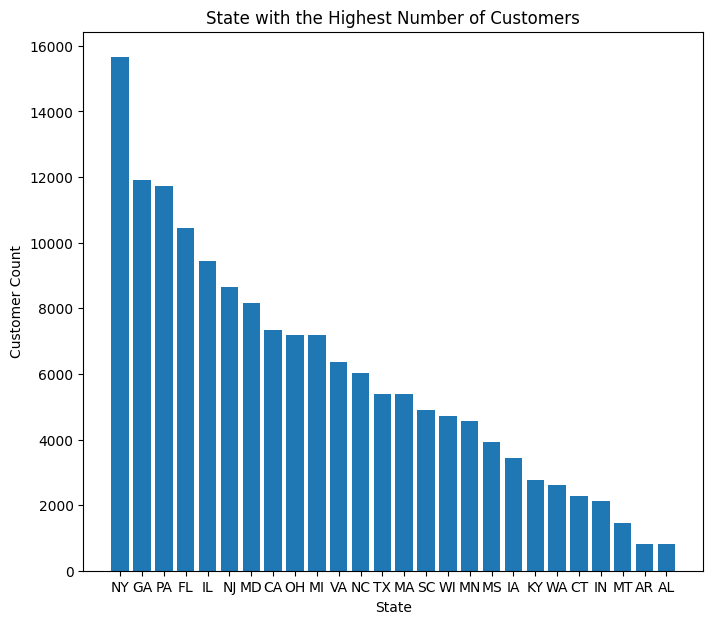

In [33]:
#Functional Requirements 3.1Find and plot which transaction type has 
#the highest transaction count

def highest_customers_state(): #To access it call this function

 

    conn = mysql.connector.connect(database='creditcard_capstone',
                                user = secret.mysql_username,
                               password = secret.mysql_password)
    cursor = conn.cursor() 
    try:
     
        # selct the highst transaction and state from cdw_sapp_custmer
        #data
            
        query = """SELECT CUST_STATE, COUNT(*) AS CUSTOMER_COUNT
                FROM cdw_sapp_custmer GROUP BY CUST_STATE 
                ORDER BY CUSTOMER_COUNT DESC """
        cursor.execute(query)
        
        data = cursor.fetchall()  #Fectch the result into dataframe
        df = pd.DataFrame(data, columns = ['CUST_STATE','CUSTOMER_COUNT'])
        print(df)
        plt.figure(figsize=(8,7))

        plt.bar(df['CUST_STATE'], df['CUSTOMER_COUNT'])
        plt.title("State with the Highest Number of Customers")
        plt.xlabel("State")
        plt.ylabel("Customer Count")
        #Add a grid lines
        # plt.grild(True, linestyle = '--', alpha =0.7)
        plt.show()
        cursor.close()

    except Error as e:
        print(e)
    finally:
      conn.close()

highest_customers_state()

    



  TRANSACTION_TYPE  TRANSACTION_COUNT
0            Bills             583185
1       Healthcare             571455
2             Test             568055
3        Education             564230
4    Entertainment             563975
5              Gas             561425
6          Grocery             556665


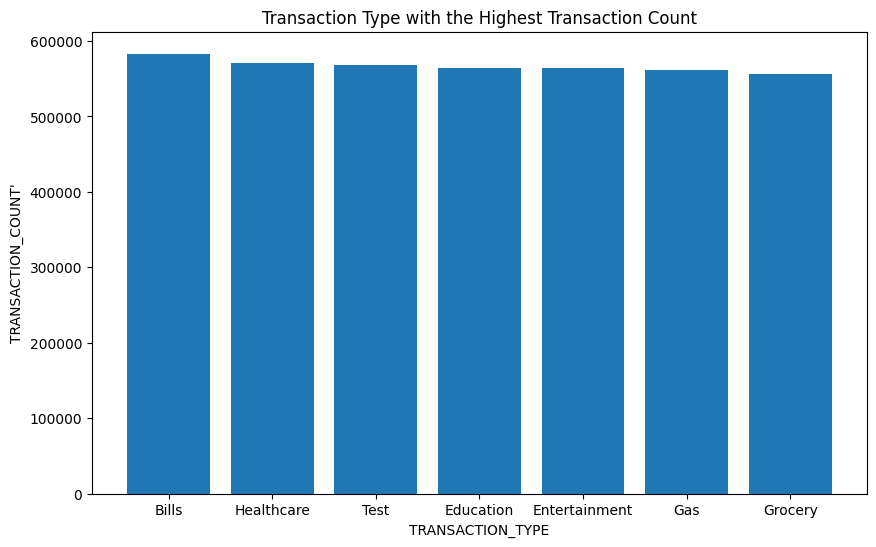

In [34]:
# Find and plot which transaction type has the highest transaction count.

def highest_transaction_type(): #To access it call this function

    conn = mysql.connector.connect(database='creditcard_capstone',
                               user = secret.mysql_username,
                               password = secret.mysql_password)
    cursor = conn.cursor() 
 
    try:
        conn = mysql.connector.connect(database='creditcard_capstone',
                                user = secret.mysql_username,
                               password = secret.mysql_password)
        cursor = conn.cursor() 
     
        # selct the highst transaction and state from cdw_sapp_custmer
        #data
            
        query = """SELECT TRANSACTION_TYPE,COUNT(*) AS TRANSACTION_COUNT
                FROM  cdw_sapp_credit GROUP BY TRANSACTION_TYPE 
                ORDER BY TRANSACTION_COUNT DESC """
        cursor.execute(query)
        
        data = cursor.fetchall()  #Fectch the result into dataframe
        df = pd.DataFrame(data, columns = ['TRANSACTION_TYPE','TRANSACTION_COUNT'])
        print(df)
        plt.figure(figsize=(10,6))

        plt.bar(df['TRANSACTION_TYPE'], df['TRANSACTION_COUNT'])
        plt.title("Transaction Type with the Highest Transaction Count")
        plt.xlabel("TRANSACTION_TYPE")
        plt.ylabel("TRANSACTION_COUNT'")
        #Add a grid lines
        #.grild(True, linestyle = '--')
        plt.show()
        cursor.close()

    except Error as e:
        print(e)
    finally:
      conn.close()



highest_transaction_type()


    CUST_SSN      TOTAL
0  123451125  478810.95
1  123452783  471591.90
2  123453486  465466.80
3  123458668  451772.45
4  123456678  447187.55
5  123452026  445500.30
6  123452518  444036.60
7  123454933  442261.80
8  123457547  437728.75
9  123452085  436329.65


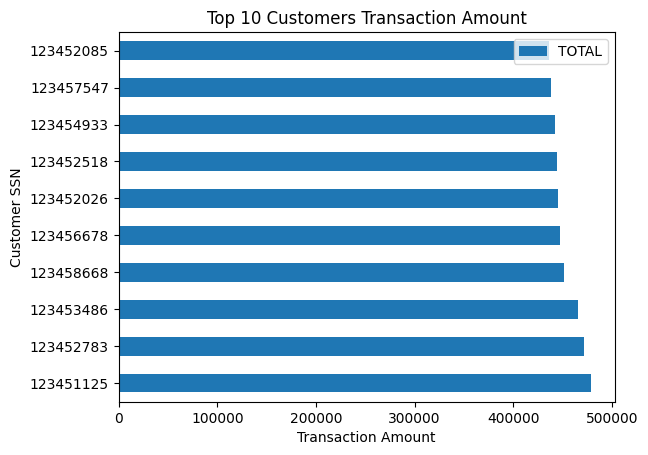

<Figure size 1000x700 with 0 Axes>

In [37]:
#Functional Requirements 3.3 Find and plot the sum of all transactions for the
# top 10 customers,and which customer has the highest transaction amount.

def top10_transaction():
 
 try: 
        conn = mysql.connector.connect(database='creditcard_capstone',
                               user = secret.mysql_username,
                               password = secret.mysql_password)
        cursor = conn.cursor() 

        # selct the total transaction from cdw_sapp_credit  
        quary = """SELECT CUST_SSN, SUM(TRANSACTION_VALUE) AS TOTAL 
                FROM cdw_sapp_credit
                GROUP BY CUST_SSN ORDER BY TOTAL DESC  LIMIT 10"""

        cursor.execute(quary)

        top_10 = cursor.fetchall()

        df = pd.DataFrame(top_10, columns = ['CUST_SSN','TOTAL'])
        print(df)
        df.plot.barh(x = 'CUST_SSN', y = 'TOTAL')
        plt.title("Top 10 Customers Transaction Amount")
        plt.xlabel("Transaction Amount")
        plt.ylabel("Customer SSN")
        plt.figure(figsize=(10,7))
        plt.show()
        
 except Exception as e:
        print("error")
        conn.rollback()
 finally:
        cursor.close()
        conn.close()

top10_transaction()

#plot 

 

 LOAN Application Dataset


Req-4 Access to Loan API Endpoint
Functional Requirements 4.1
Create a Python program to GET (consume) data from the above API endpoint for the loan application dataset.
Functional Requirements 4.2 Find the status code of the above API endpoint. Hint: status code could be 200, 400, 404, 401.
Functional Requirements 4.3 Once Python reads data from the API, utilize PySpark to load data into
RDBMS (SQL). The table name should be CDW-SAPP_loan_application in the database. Note: Use the “creditcard_capstone” database.

In [38]:
""" 4. Functional Requirements - LOAN Application Dataset  
 On this part of project I used  LOAN Application dataset. First https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json 
 request acces from a REST API by sending an HTTP request and processing the response. After got the respond load it to pyspark and load it on database. 
 Finally create o analyze and visualize the data.
"""

def Loan_Application_dataset():
    spark = SparkSession.builder.appName('Loan Application dataset').getOrCreate()

    # Create a Python program to GET (consume) data from the above API
    # endpoint for the loan application dataset.

    url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"

    #Request the API endpoint
    response = requests.get(url)
    data_loan = response.json()  #get Json data from the response

    """Find the status code of the above API endpoint.
    Hint: status code could be 200, 400, 404, 401"""

    print(f"The request status code is: {response.status_code}" )  # print response.status_code

    """Once Python reads data from the API, utilize PySpark to load data into
    RDBMS (SQL). The table name should be CDW-SAPP_loan_application
    in the database.Note: Use the “creditcard_capstone” database."""

    #Load in to spark dataframe
    data_loan_df = spark.createDataFrame(data_loan)

    # #Define  properties to connect to database
    mysql_properties = {
        "user":  secret.mysql_username,
    "password" :  secret.mysql_password,
    "drive": "com.msql.cj.jdbc.Driver",
    }


    table_name = "`CDW_SAPP_loan_application`"

    data_loan_df.write.format("jdbc") \
        .mode("overwrite") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("dbtable", table_name) \
        .option("user", secret.mysql_username) \
        .option("password",secret.mysql_password) \
        .save()

    data_loan_df.show()
    spark.stop()

Loan_Application_dataset()

The request status code is: 200
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     

Data Analysis and Visualization for LOAN
Application

Req-5 Data Analysis and Visualization
Functional Requirements 5.1 :Find and plot the percentage of applications approved for self-employed applicants.
Functional Requirements 5.2 Find the percentage of rejection for married male applicants.
Functional Requirements 5.3 Find and plot the top three months with the largest volume of transaction data.
Functional Requirements 5.4 Find and plot which branch processed the highest total dollar value of healthcare transactions.

In [67]:
#Functional Requirements 5.1 :Find and plot the percentage of applications approved for self-employed applicants.
#for the CDW_SAPP_loan_application data table from  creditcard_capstone database
#select approved self-employeed  (yes)and application status(Y)


def approved_self_employed_applicants():

 
    conn = mysql.connector.connect(database='creditcard_capstone',
                                user = secret.mysql_username,
                               password = secret.mysql_password)
    cursor = conn.cursor() 
    try:
     
        # for the CDW-SAPP_loan_application data table from  creditcard_capstone database
        #select approved self-employeed  (yes)and application status(Y) and count "N"
        query = """SELECT Self_Employed, Application_status, COUNT(*) AS total_Approved_applicant
                 FROM CDW_SAPP_loan_application  
                 WHERE Application_Status ='Y' and Self_Employed ='Yes'; 
                 GROUP BY Self_Employed, Application_status
                 """
        
        #data frame column
        cursor.execute(query)
        data = cursor.fetchall()

        
        df = pd.DataFrame(data, columns=['Self_Employed', 'Application_Status', 'total_Approved_applicant'])
        print(df)

        total_self_employed = len(df)
        total_approved_self_employed = len(df[df['Application_status'] == 'Y'])
        total_not_approved_self_employed = len(df[df['Application_status'] == 'N'])
        

        approval_percentage = (total_approved_self_employed/ total_self_employed)*100

        # Create a bar chart to visualize the percentage
        labels = ['Approved ','Not Approved']
        
        percentages = [approval_percentage, 100 - approval_percentage]
        colors = ['purple','orange']
        
        plt.pie( percentages, labels = labels, colors = colors, autopct = '%1.1f%%' )
        plt.title ('Percentage os Applications Approved for Self-Employed Applicants') 
        plt.show ()
        
    except Exception as e:
            print("error")
            conn.rollback()
            
    finally:
            cursor.close()
            conn.close()
approved_self_employed_applicants()



 

  Self_Employed Application_Status  total_Approved_applicant
0           Yes                  Y                        46
error


MySQLInterfaceError: Commands out of sync; you can't run this command now

    Application_Status
0                    Y
1                    Y
2                    Y
3                    Y
4                    N
..                 ...
301                  Y
302                  Y
303                  Y
304                  Y
305                  Y

[306 rows x 1 columns]


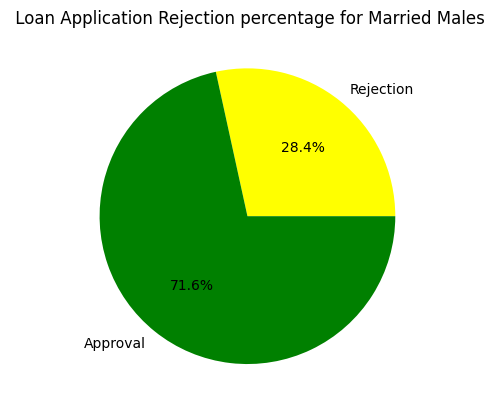

In [63]:
#Find the percentage of rejection for married male applicants


def reject_percentage_for_married_male():

 
    conn = mysql.connector.connect(database='creditcard_capstone',
                                user = secret.mysql_username,
                               password = secret.mysql_password)
    cursor = conn.cursor() 
    try:
        query = """SELECT Application_Status FROM CDW_SAPP_loan_application
               WHERE Application_Status = 'N' AND Gender = 'Male' AND Married = 'Yes'; """
        
        cursor.execute (query ) 
        data = cursor.fetchall ()

        # Create a DataFrame from the query result 
        df= pd.DataFrame(data, columns = ['Application_Status']) 
      # Count the number of rejected married male applicants 
        total_rejected = len(df )  
        
        #SQL query to select total married male applicants
        query = """SELECT Application_Status 
         FROM CDW_SAPP_loan_application
         WHERE Gender = 'Male' AND Married = 'Yes'; """
        
        cursor.execute (query ) 
        data= cursor.fetchall () # Create a DataFrame from the query result 
        df = pd.DataFrame(data, columns = ['Application_Status']) # Count the total number of married male applicants 
        total_married_males = len(df) 
        print(df)
      # Calculate the rejection percentage
        rejection_percentage = (total_rejected / total_married_males) * 100
        approval_percentage = 100 - rejection_percentage

        labels = ['Rejection', 'Approval'] 
        percentages = [rejection_percentage, approval_percentage ] 
        colors = ['yellow', 'green']
      
        plt.pie( percentages, labels = labels, colors = colors, autopct = '%1.1f%%' )
        plt.title (' Loan Application Rejection percentage for Married Males') 
        plt.show ()
        
    except Exception as e:
            print("error")
            conn.rollback()
    finally:
            cursor.close()
            conn.close()

reject_percentage_for_married_male()



 